In [12]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [13]:
output = pickle.load(open("result.p","rb"))
original_train = pd.read_excel("original_train.xlsx",index_col=0).to_dict()['accuracy']
VGG16_layers = pd.read_excel("VGG16_layers.xlsx",index_col=0)

In [14]:
def format_result(result, experiments):
    formatted_result = {}
    experiment_counter = 0

    for experiment, result in result.items():
        iterations = 4224 / experiments[experiment_counter]
        iterations = int(iterations * pruning_target)

        recovery_epochs = 5
        fine_tuning_epochs = 10

        accuracy = {}
        running_time = {}
        running_time['Total'] = result['time'][-1] - result['time'][0]
        accuracy['start'] = result['accuracy'][0]
        accuracy_counter = 1
        time_counter = 1

        for iteration in range(iterations):
            accuracy["iteration {0}".format(iteration)] = result['accuracy'][accuracy_counter:accuracy_counter+6]
            accuracy_counter += 6
          
            running_time["iteration {0}: total time".format(iteration)] = result['time'][time_counter+3] - result['time'][time_counter]
            running_time["iteration {0}: ranking".format(iteration)] = result['time'][time_counter+1] - result['time'][time_counter]
            running_time["iteration {0}: pruning".format(iteration)] = result['time'][time_counter+2] - result['time'][time_counter+1]
            running_time["iteration {0}: fine-tuning".format(iteration)] = result['time'][time_counter+3] - result['time'][time_counter+2]
          
            time_counter += 4
        
        accuracy['finetuning'] = result['accuracy'][-10:]
        running_time['finetuning'] = result['time'][-1] - result['time'][-2]

        experiment_counter += 1

        formatted_result[experiment] = {'Accuracy':accuracy, 'Running time':running_time}

    return formatted_result

In [68]:
experiments = [132,264,528,1056]
number_of_layers = 4224
pruning_target = 0.75
formatted_output = format_result(output,experiments)

# Accuracy barchart

In [71]:
accuracy_plot = {'original_model':{},132: {}, 264: {}, 528: {}, 1056: {}}
accuracy_plot['original_model']['start_accuracy'] = original_train[0]
accuracy_plot['original_model']['end_accuracy'] = original_train[list(original_train.keys())[-1]]

for experiment,result in formatted_output.items():
    accuracy_plot[experiment]['start_accuracy'] = formatted_output[experiment]['Accuracy']['start']
    accuracy_plot[experiment]['end_accuracy'] = formatted_output[experiment]['Accuracy']['finetuning'][-1]

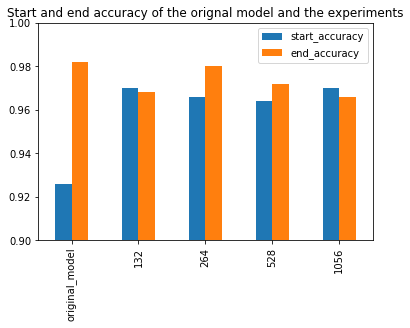

In [17]:
accuracy = pd.DataFrame(accuracy_plot).transpose()
accuracy = accuracy[["start_accuracy", "end_accuracy"]]
accuracy.plot.bar(title="Start and end accuracy of the orignal model and the experiments",ylim = (0.9, 1))

# Accuracy linegraph

In [132]:
parameters = {132: {}, 264: {}, 528: {}, 1056: {}}
for experiment in experiments:
    number_of_iterations = int((number_of_layers * pruning_target) / experiment)
    for iteration in range(number_of_iterations):
        parameters[experiment][iteration+1] = round((number_of_layers - (iteration+1) * experiment)/number_of_layers,4)*100

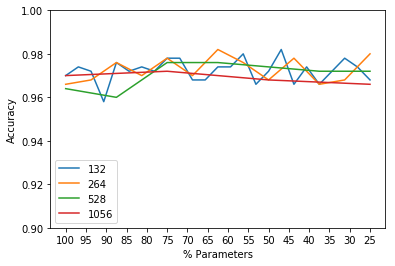

In [160]:
plot_data = {132: {}, 264: {}, 528: {}, 1056: {}}
#plot the results
for experiment, result in formatted_output.items():
    plot_accuracy = {}
    for key, value in result['Accuracy'].items():
        if key == "start":
            plot_accuracy[100] = value
        elif key == "finetuning":
            plot_accuracy[100 - 100*pruning_target] = value[-1]
        else:
            iteration_number = int(key.split()[-1])+1
            plot_accuracy[parameters[experiment][iteration_number]] = value[-1]
    plt.plot(plot_accuracy.keys(),plot_accuracy.values())

plt.gca().invert_xaxis()
#ax.set_title("Accuracy when pruning {} filters per iteration".format(experiment))
plt.xticks(list(range(100,20,-5)))
plt.xlabel("% Parameters")
plt.ylabel("Accuracy")
plt.ylim(0.90,1)
plt.legend(experiments)

# Plotting running time

In [19]:
total_runtimes = {132: {}, 264: {}, 528: {}, 1056: {}}
for experiment, result in formatted_output.items():
    total_runtimes[experiment]["Total"] = formatted_output[experiment]['Running time']['Total']
    total_runtimes[experiment]["Final finetuning"] = formatted_output[experiment]['Running time']['finetuning']
    
    ranking = 0
    pruning = 0
    fine_tuning = 0
    for key, value in result['Running time'].items():
        if "ranking" in key:
            ranking += value
        if "pruning" in key:
            pruning += value
        if "fine-tuning" in key:
            fine_tuning += value
    
    total_runtimes[experiment]["Ranking"] = ranking
    total_runtimes[experiment]["Pruning"] = pruning
    total_runtimes[experiment]["Finetuning"] = fine_tuning

In [20]:
running_times = pd.DataFrame(total_runtimes)
running_times = running_times.reindex(["Ranking","Pruning","Finetuning","Final finetuning","Total"])

In [21]:
running_times

,132,264,528,1056
Ranking,578.006429,307.110102,156.008749,83.935743
Pruning,433.577141,430.629871,429.938321,428.792267
Finetuning,3872.025332,1966.649972,933.481560,439.255249
Final finetuning,179.893858,192.441276,182.924634,187.607593
Total,5063.502862,2896.832491,1702.353328,1139.590896


Text(0,0.5,'Running time in seconds')

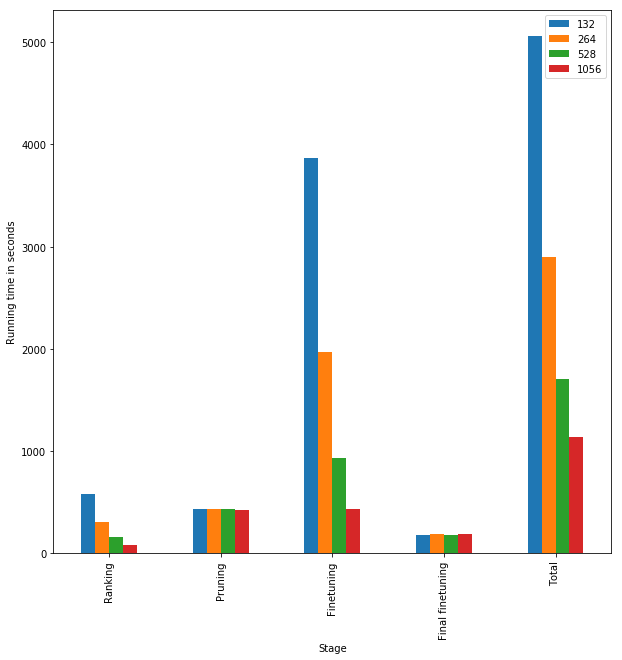

In [163]:
ax = running_times.plot.bar(figsize=(10,10))
#x.set_title("Running times for the stages of the experiments")
ax.set_xlabel("Stage")
ax.set_ylabel("Running time in seconds")

# Accuracy & running time

In [63]:
accuracy_runningtime = {132: {}, 264: {}, 528: {}, 1056: {}}
original_accuracy = original_train[list(original_train.keys())[-1]]
for experiment, result in formatted_output.items():
    model_accuracy = result['Accuracy']['finetuning'][-1]
    accuracy_runningtime[experiment]['Accuracy'] = result['Accuracy']['finetuning'][-1]
    accuracy_runningtime[experiment]['Accuracy loss'] = "{}%".format(round(((model_accuracy-original_accuracy)/original_accuracy)*100,2))
    accuracy_runningtime[experiment]['Running time'] = result['Running time']['Total']

In [64]:
pd.DataFrame(accuracy_runningtime)

,132,264,528,1056
Accuracy,0.968,0.98,0.972,0.966
Accuracy loss,-1.43%,-0.2%,-1.02%,-1.63%
Running time,5063.5,2896.83,1702.35,1139.59
